# VLM for KOMO

In [90]:
import re
import rowan
import torch
import numpy as np
import robotic as ry
import matplotlib.pyplot as plt

# from prompting import prompt_qwen
from high_level_funcs import RobotEnviroment

In [91]:
torch.cuda.empty_cache()

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")

Using cpu


## Prepare your scene

In [93]:
C = ry.Config()
C.addFile(ry.raiPath("scenarios/pandaSingleWithTopCamera.g"))

C.addFrame("box") \
    .setPosition([.3, 0.05, 0.72]) \
    .setShape(ry.ST.ssBox, size=[0.04, 0.04, 0.04, 0.001]) \
    .setColor([1., 0., 0.]) \
    .setContact(1) \
    .setMass(.1)
C.view()

0

## Define your model (VLM)

In [94]:
# from transformers import Qwen2VLForConditionalGeneration, AutoProcessor

# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct",
#     torch_dtype="auto",
#     device_map=device
# )
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

## Take a picture of the scene

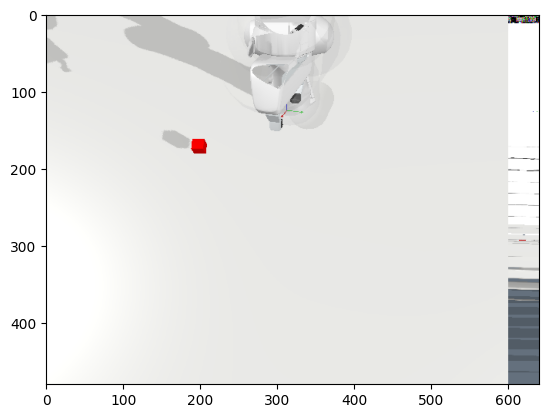

In [95]:
C.view()
C.view_setCamera(C.getFrame("topCamera"))
rgb = C.view_getRgb()

img_idx = 1
image_path = "./scene_image0.jpg"
plt.imsave(image_path, rgb)
plt.imshow(rgb)

## Prepare initial prompt

In [96]:
# task_description = "Put the blob in the bin."

# with open("./prompts/high_tutorial.txt", 'r') as file:
#     tutorial = file.read()

# with open("./prompts/problem_definition.txt", 'r') as file:
#     problem_definition = file.read()

# frame_names = [line for line in C.getFrameNames() if not line.startswith("l_")]
# frame_names.append("l_gripper")
# frame_names.append("l_palm")

# messages = [
#     {
#         "role": "user",
#         "content": [
#             {
#                 "type": "text",
#                 "text": tutorial,
#             },
#             {
#                 "type": "image",
#                 "image": "./example_image.jpg",
#             },
#             {
#                 "type": "text",
#                 "text": f"{problem_definition}{task_description}",
#             },
#             {
#                 "type": "text",
#                 "text": f"Here is a list of all available frames: {frame_names}",
#             },
#         ],
#     },
# ]
messages = []

## Loop until the problem in solved

  -- feasible:
     { time: 0.007403, evals: 54, done: 1, feasible: 1, eq: 4.05322e-07, ineq: 4.0913e-07, sos: 0.020053, f: 0 }
  -- feasible:sub_motion_0--
     { time: 0.027921, evals: 17, done: 1, feasible: 1, eq: 0.000165015, ineq: 1.30343e-07, sos: 0.797469, f: 0 }
[-0.105, 0.4]
  -- infeasible:
     { time: 0.023925, evals: 104, done: 1, feasible: 0, eq: 1.58156, ineq: 0.437226, sos: 0.0792761, f: 0 }


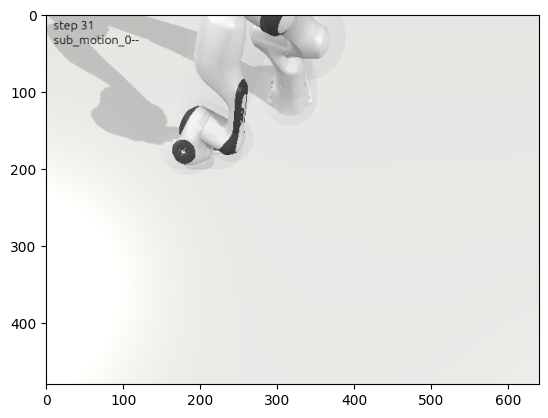

In [97]:
ATTEMPT_COUNT = 10

for i in range(ATTEMPT_COUNT):
    # action_sequence: str = prompt_qwen(model, processor, device, messages)
    action_sequence = """
pick("box")
place(-0.105, 0.4)
push("box", -0.3, 0.4)
"""

    system_message = {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": action_sequence,
            },
        ],
    }
    messages.append(system_message)

    env = RobotEnviroment(C, visuals=True, verbose=1)
    success = True
    for line in action_sequence.splitlines():
        if line.startswith("pick"):
            frame = re.findall(r'"(.*?)"', line)[0]
            success = env.pick(frame)

        elif line.startswith("place"):
            matches = re.findall(r'-?\d+\.?\d*', line)
            coors = [float(match) for match in matches]
            print(coors)
            success = env.place(*coors)
        
        elif line.startswith("push"):
            frame = re.findall(r'"(.*?)"', line)[0]
            matches = re.findall(r'-?\d+\.?\d*', line)
            coors = [float(match) for match in matches]
            success = env.push(frame, *coors)
        
        else:
            continue

        if not success:
            break
    
    C.view()
    C.view_setCamera(C.getFrame("topCamera"))
    rgb = C.view_getRgb()

    image_path = f"./scene_image{img_idx}.jpg"
    plt.imsave(image_path, rgb)
    plt.imshow(rgb)
    img_idx += 1

    break

    user_message = {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {
                "type": "text",
                "text": "Looking at this image, would you say that the task has been solved correctly? Start with a simple yes or no, then explain your answer.",
            },
        ],
    }
    messages.append(user_message)

    image_evaluation = prompt_qwen(model, processor, device, messages)
    system_message = {
        "role": "system",
        "content": [
            {
                "type": "text",
                "text": image_evaluation,
            },
        ],
    }
    messages.append(system_message)

    print(image_evaluation)
    print("-"*30)
    s = image_evaluation.strip().lower()

    if s.startswith("yes"):
        break
    else:
        user_message = {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Retry generating the action sequence as defined previously.",
                },
            ],
        }
        messages.append(user_message)